In [5]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil

seed = 7
tf.random.set_seed(seed)

In [6]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [7]:
scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global scaler
    
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test_blind = test.to_numpy().astype(np.float64)
    
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        y_train = scaler.fit_transform(y_train)
        
        
    return x_train, y_train, x_test, y_test, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [8]:
def mee(y_true_t, y_pred_t):
    '''y_true = y_true_t.numpy()
    y_pred = y_pred_t.numpy()
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    return np.sqrt(np.square(y_true - y_pred).sum(axis=1)).mean()'''
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))

In [203]:
class RandomizedNetwork(keras.Model):
    
    def __init__(self, input_size, output_size, hidden_units, activation="relu", init=None, reg=None):
        super().__init__()
        
        if init is None:
            init = initializers.RandomNormal(mean=0, stddev=1, seed=None)
        else:
            if init["type"] == "uniform":
                min_val = init["min"]
                max_val = init["max"]
                init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
            elif init["type"] == "normal":
                mean = init["mean"]
                std = init["std"]
                init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
        
        self.reg = reg
        
        self.model = Sequential()
                    
        self.model.add(Dense(hidden_units, input_dim=input_size, activation=activation,
                    kernel_initializer = init, bias_initializer = init))
        
        self.model.add(Dense(output_size, activation="linear",
                    kernel_initializer = init, bias_initializer = init))
        
        self.model.layers[0].trainable = False
                
    def lms_solve(self, x, y):
        
        n = x.shape[0]
        
        # x_b = np.append(x, np.ones((n,1)), axis=-1)
        
        H = self.model.layers[0](x).numpy()
        
        # if regularization is used apply direct solution
        if self.reg is not None:
            H = np.append(H, np.ones((n,1)), axis=-1)
            H_t = H.transpose()
            H = np.matmul(H_t, H)
            I = np.identity(H.shape[0])
            H = H + self.reg*I
            H_star = np.linalg.inv(H)
            W = np.matmul(H_star, H_t)
            W = np.matmul(W, y)
            b = W[-1:][0]
            W = W[:-1]
        # if regularization is not used apply numpy LMS solver
        else:
            W, _, _, _ = np.linalg.lstsq(H.T.dot(H), H.T.dot(y))
            b = W[-1:][0]
            W = W[:-1]
        
        self.model.layers[1].set_weights([W, b])

        
    def call(self, x):
        return self.model(x)
        

# ML Cup

In [204]:
x_train, y_train, x_test, y_test, x_test_blind = load_dataset("cup", False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_test_blind.shape)

(1342, 9) (1342, 2)
(150, 9) (150, 2)
(529, 9)


In [206]:
input_size = 9
output_size = 2
init = {
    "type": "normal",
    "mean": 0,
    "std": 1
}

ELM = RandomizedNetwork(input_size, output_size, 100, "relu", init, 0.1)
ELM(x_train).shape
optimizer = SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
ELM.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = mee)
ELM.summary()

ELM.lms_solve(x_train, y_train)
print("Traing set accuracy")
print(ELM.evaluate(x_train, y_train))

print("\nTest set accuracy")
print(ELM.evaluate(x_test, y_test))

Model: "randomized_network_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_96 (Sequential)  (None, 2)                 1202      
                                                                 
Total params: 1,202
Trainable params: 202
Non-trainable params: 1,000
_________________________________________________________________
Traing set accuracy
42/42 [==============================] - 0s 1ms/step - loss: 1.8695 - mee: 1.5862
[1.8695454597473145, 1.586214542388916]

Test set accuracy
5/5 [==============================] - 0s 1ms/step - loss: 2.3309 - mee: 1.7929
[2.330873966217041, 1.7928974628448486]


42/42 [==============================] - 0s 1ms/step


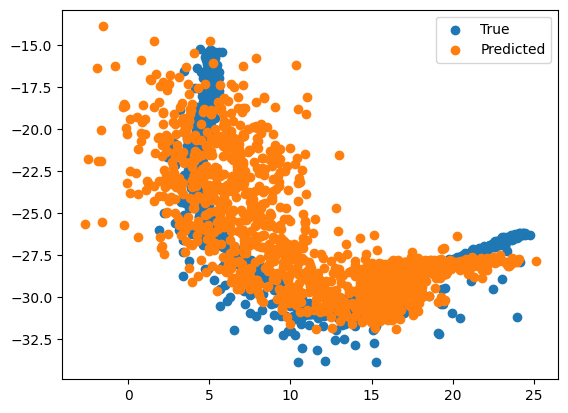

In [167]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = ELM.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

5/5 [==============================] - 0s 2ms/step


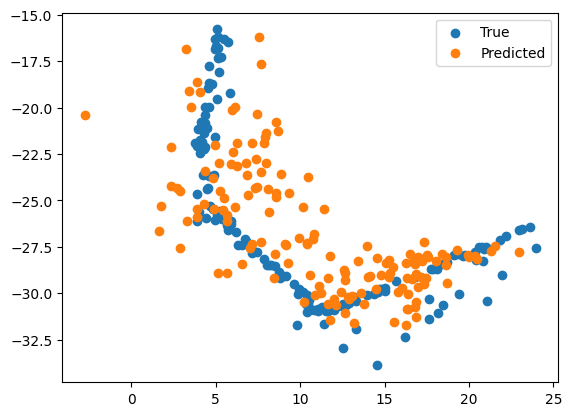

In [168]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = ELM.predict(x_test)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()